In [16]:
from nbodykit.source.catalog import CSVCatalog
from nbodykit.algorithms.paircount_tpcf.tpcf import SimulationBox2PCF
from nbodykit.cosmology.correlation import CorrelationFunction
from nbodykit.cosmology.power.halofit import HalofitPower
from nbodykit.cosmology import Cosmology

In [17]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

In [18]:
bins = np.array([ 0.31622777,  0.54116953,  0.92611873,  1.58489319,  2.71227258,  4.64158883,
  7.94328235, 13.59356391, 23.26305067, 39.81071706])[3:]
#xi_obs = np.array([6.80923260e+01, 4.33056847e+01, 2.07783072e+01, 7.18173688e+00,
# 2.22463378e+00, 8.60030502e-01, 3.65222004e-01, 1.39703596e-01,
# 4.46076223e-02])[3:]
xi_obs = np.array([4.65850963e+01, 2.67169292e+01, 1.24204115e+01, 4.17146890e+00,
 1.47628267e+00, 6.37976747e-01, 2.92537692e-01, 1.23257133e-01,
 4.61223291e-02])[3:]
bc = (bins[1:] + bins[:-1])/2.0

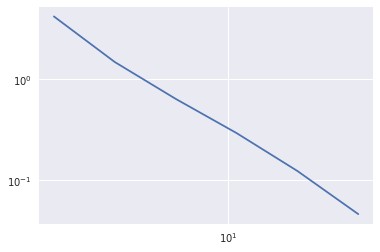

In [19]:
plt.plot(bc, xi_obs)
plt.loglog()
plt.show();

In [20]:
import h5py
f = h5py.File('../data/UatuTest4_data.hdf5', 'r')
boxno = 0
#X = np.array(f['Box%03d'%boxno]["X"])
Y = f['Box%03d'%boxno]['Y'][0]

In [21]:
Om, s8 = Y
Om*=0.7**2
Ob = 0.022
Ocdm = Om - Ob
cosmo = Cosmology(h=1.0, T0_cmb=2.726,
                  Omega_b = Ob,
                  Omega0_cdm=Ocdm,
                  P_k_max = 100.0,
                  n_s=0.96).match(s8)
bc = (bins[1:] + bins[:-1])/2.0
predicted_xi = CorrelationFunction(HalofitPower(cosmo, 0.0))(bc)

print np.sum((predicted_xi-xi_obs))**2

12.541652142367756


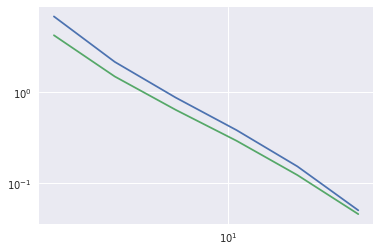

In [22]:
plt.plot(bc, predicted_xi)
plt.plot(bc, xi_obs)

plt.loglog()
plt.show();

In [23]:
Om, s8 = Y[0], 0.82#Y
Om*=0.7**2
Ob = 0.022
Ocdm = Om - Ob
cosmo = Cosmology(h=1.0, T0_cmb=2.726,
                  Omega_b = Ob,
                  Omega0_cdm=Ocdm,
                  P_k_max = 100.0,
                  n_s=0.96).match(s8)
bc = (bins[1:] + bins[:-1])/2.0
predicted_xi = CorrelationFunction(HalofitPower(cosmo, 0.0))(bc)


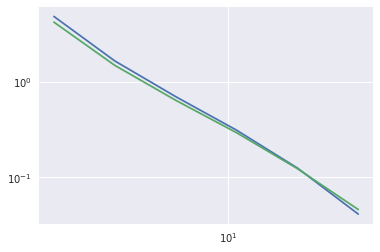

In [24]:
plt.plot(bc, predicted_xi)
plt.plot(bc, xi_obs)

plt.loglog()
plt.show();

In [25]:
mcmc_preds = np.loadtxt('simulated_chain5_10_walkers_500_steps.npy')

In [26]:
mcmc_preds.shape

(5000, 2)

In [27]:
chain_vals = []
for Om, s8 in mcmc_preds[-10:, :]:
    print Om, s8
    Om*=0.7**2
    Ob = 0.022
    Ocdm = Om - Ob
    cosmo = Cosmology(h=1.0, T0_cmb=2.726,
                      Omega_b = Ob,
                      Omega0_cdm=Ocdm,
                      P_k_max = 100.0,
                      n_s=0.96).match(s8)
    chain_vals.append(CorrelationFunction(HalofitPower(cosmo, 0.0))(bc))


0.3348590842370125 0.7992812033271649
0.32938324303011324 0.7913786396198667
0.32125825360437194 0.8311855486296079
0.3288346813143545 0.8152691392972068
0.30119411558603537 0.7842789420770933
0.3452417918691654 0.8414428711427344
0.32353840643463233 0.817390373536849
0.33161513630965783 0.8447572811184583
0.32819656107024037 0.8200625751885966
0.343054964618206 0.8337102399788642


0.07572232188936169
0.011666308567256319
1.2906769862791443
0.488438456983326
0.009727783981830973
1.595891074161162
0.5930051877817142
2.068864011671418
0.6785260732666529
1.1663818831666712


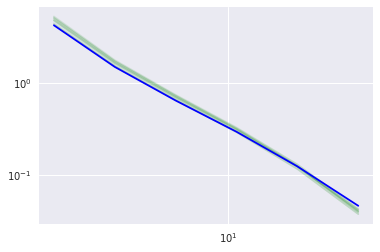

In [28]:
for cv in chain_vals:
    plt.plot(bc, cv, color = 'g', alpha = 0.1)
    print np.sum((cv-xi_obs))**2
plt.plot(bc, xi_obs, color = 'b')

plt.loglog()
plt.show();